In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random

from scipy import optimize
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def unit_vector_norm(X):
    X -= X.min() #remove noise offset
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [3]:
X = np.load("../data/HSI/Liver_map_150z25_60s_1TCPOBOP.npy", 'r')
Y = np.load("../data/HSI/Liver_map_150z25_60s_2TCPOBOP.npy", 'r')
Z = np.load("../data/HSI/Liver_map_150z25_60s_3OBOB.npy", 'r')
wavelength = np.load("../data/HSI/wavelength.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape 
shape_Z = Z.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Z = copy.copy(Z.reshape(-1, Z.shape[-1]))

In [4]:
class ReferenceVectorClassifierPCA(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.pca_kwargs = {}
        self.k_means_kwargs = {}        
        self.set_params(**kwargs)
        
    def fit(self, x, **kwargs):
        self.set_params(**kwargs)
        X = unit_vector_norm(x)
        
        ###################### PCA ################################
        pca = decomposition.PCA(**self.pca_kwargs)
        pca.fit(X)
        z = pca.transform(X)

        ###################### clustering ################################
        self.clusters = cluster.KMeans(**self.k_means_kwargs).fit(z)
        self.clusters = self.clusters.labels_
        
        one_hot = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        one_hot[range(X.shape[0]), self.clusters] = 1

        ###################### reference spectra ################################
        self.reference_spectra_ = np.array([X[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])
        self.ref_org = np.array([x[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])

        # Return the classifier
        return self

    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X = unit_vector_norm(X)
        
        ###################### RCA ################################
        old_mask = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        mask = np.ones((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        while np.abs(old_mask ^ mask).sum():
            RCA_vector = np.array([optimize.nnls(self.reference_spectra_.T * mask[i], X[i,:])[0] for i in range(X.shape[0])])
            old_mask, mask = mask, (RCA_vector.T / RCA_vector.sum(axis=1)).T >= self.kwargs['min_weight']            
        
        return RCA_vector  
    
    def get_reference_vectors(self):
        return self.reference_spectra_
    
    def get_org_reference_vectors(self):
        return self.ref_org

    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.pca_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(decomposition.PCA).parameters.keys())})
        self.k_means_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(cluster.KMeans).parameters.keys())})     
        return self

In [5]:
def error_map(estimator, X, y=None):
    RCA = estimator.predict(X)
    ref_vec = estimator.get_reference_vectors()
    return ((RCA @ ref_vec - X)**2).mean(1)

def score_func(estimator, X, y=None):  
    X = unit_vector_norm(X)
    return error_map(estimator, X).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    rvc.fit(np.concatenate((X, Y), axis=0))
    return score_func(rvc, Z)


In [14]:
kwargs = {'n_clusters': 3,
          'n_components': 5,
          'min_weight': 0}

header = f"{'mean':12}{'std':12}"

In [15]:
################################# cross_val_score #######################
rvc = ReferenceVectorClassifierPCA(**kwargs)
print(f"{'':18}| {header}")
print(f"cross_val_score X | {print_mean_std(model_selection.cross_val_score(rvc, X, None, scoring=score_func))}")
print(f"cross_val_score Y | {print_mean_std(model_selection.cross_val_score(rvc, Y, None, scoring=score_func))}")
print(f"cross_val_score Z | {print_mean_std(model_selection.cross_val_score(rvc, Z, None, scoring=score_func))}")

                  | mean        std         
cross_val_score X | 4.4979e-06  2.6963e-06  
cross_val_score Y | 8.4037e-06  5.3911e-06  
cross_val_score Z | 4.5143e-06  3.2749e-06  


In [16]:
################################# cross_val_score #######################
rvc = ReferenceVectorClassifierPCA(**kwargs)
print(f"{'':25}| {header}")
print(f"cross_val_score X&Y -> Z | {print_mean_std(cross_val_X_Y_Z(rvc, X, Y, Z))}")
print(f"cross_val_score Y&Z -> X | {print_mean_std(cross_val_X_Y_Z(rvc, Y, Z, X))}")
print(f"cross_val_score Z&X -> Y | {print_mean_std(cross_val_X_Y_Z(rvc, Z, X, Y))}")

                         | mean        std         
cross_val_score X&Y -> Z | 3.1822e-06  0.0000e+00  
cross_val_score Y&Z -> X | 3.8283e-06  0.0000e+00  
cross_val_score Z&X -> Y | 8.4894e-06  0.0000e+00  


fit score:  2.056823403811627e-06


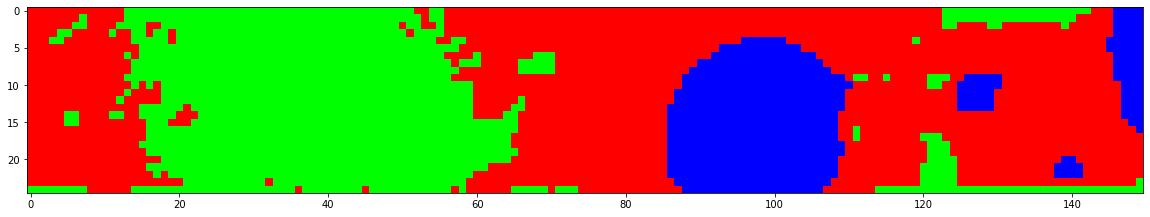

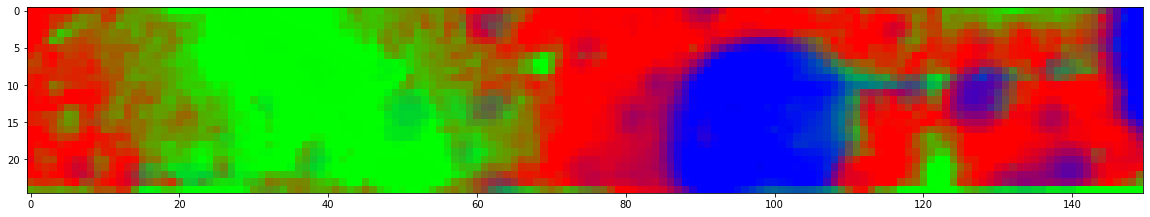

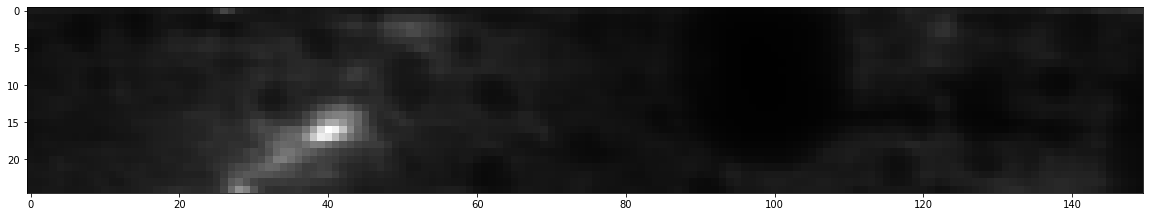

In [17]:
################# predict on original image ###############################
rvc = ReferenceVectorClassifierPCA(**kwargs)
rvc.fit(X)

RCA_vector = rvc.predict(X)

print("fit score: ", score_func(rvc, X))

one_hot = np.zeros((X.shape[0], rvc.kwargs['n_clusters']), dtype=float)
one_hot[range(X.shape[0]), rvc.clusters] = 1

plt.figure(figsize = (20,4))
plt.imshow(np.swapaxes(one_hot.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[::-1,:,:3])
plt.show()

RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.figure(figsize = (20,4))
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[::-1,:,:3])
plt.show()
plt.figure(figsize = (20,4))
plt.imshow(error_map(rvc, X).reshape(shape_X[:2]).T, cmap='gray', vmin=0)
plt.show()


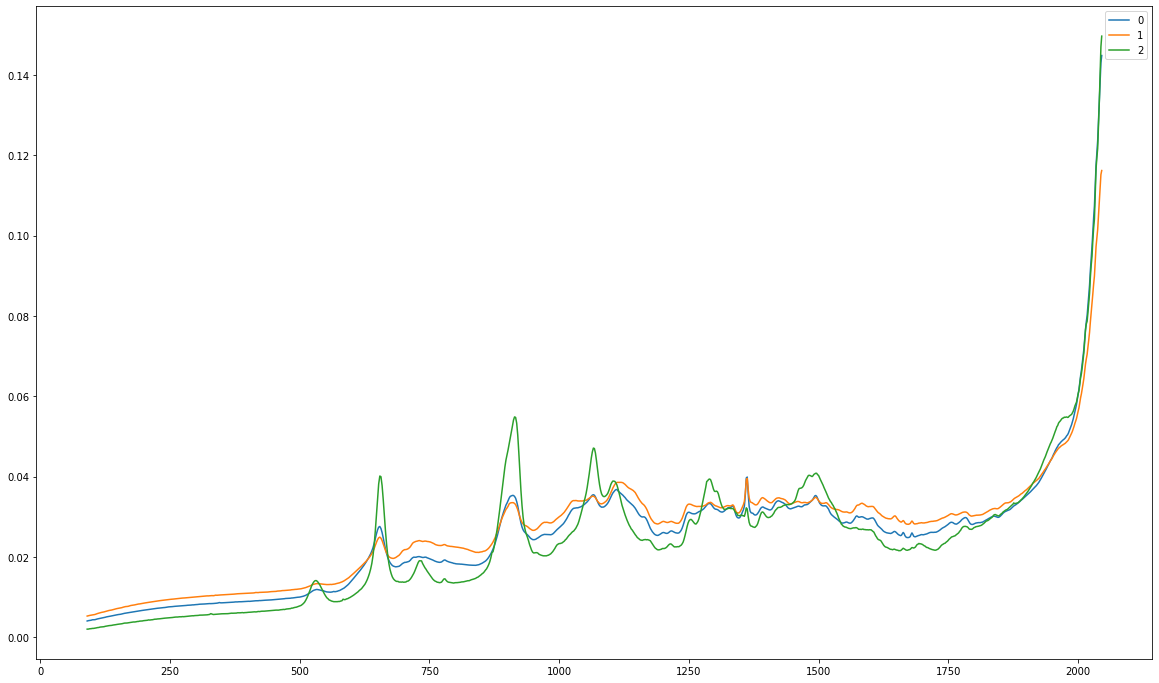

In [18]:
plt.figure(figsize = (20,12))
for i, r in enumerate(rvc.get_reference_vectors()):
    plt.plot(wavelength, r, label=i)
plt.legend()
plt.show()

fit score:  8.855618010594918e-06


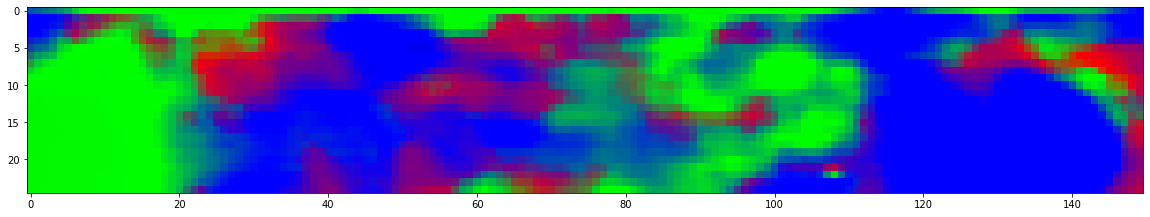

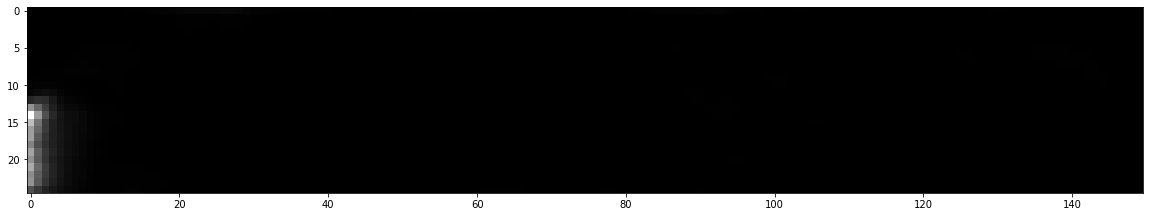

In [19]:
################# predict on new image ###############################
RCA_vector = rvc.predict(Y)

print("fit score: ", score_func(rvc, Y))

plt.figure(figsize = (20,4))
RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_Y[:2], kwargs['n_clusters'])),0,1)[:,:,:3])
plt.figure(figsize = (20,4))
plt.imshow(error_map(rvc, Y).reshape(shape_Y[:2]).T, cmap='gray', vmin=0)
plt.show()

fit score:  3.6363900941092163e-06


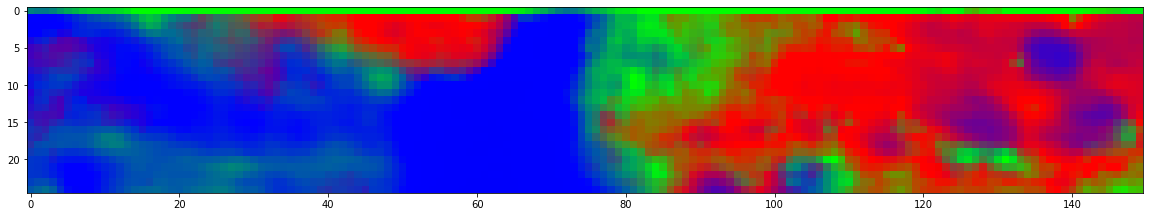

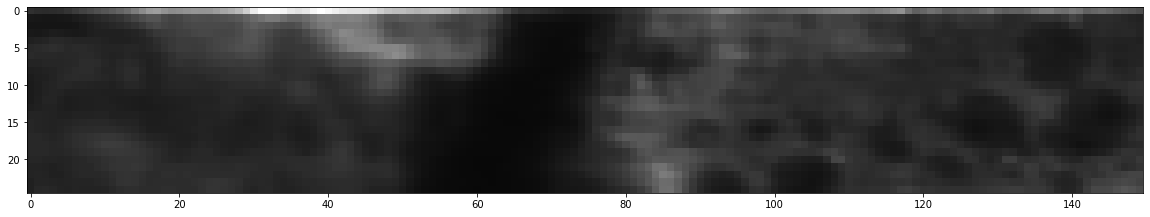

In [20]:
################# predict on new image ###############################
RCA_vector = rvc.predict(Z)

print("fit score: ", score_func(rvc, Z))

plt.figure(figsize = (20,4))
RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_Z[:2], kwargs['n_clusters'])),0,1)[:,:,:3])
plt.figure(figsize = (20,4))
plt.imshow(error_map(rvc, Z).reshape(shape_Z[:2]).T, cmap='gray', vmin=0)
plt.show()

In [13]:
# ################################# GridSearchCV #######################
# kwargs = {'n_clusters': 3,
#           'n_components': 20,
#           'min_weight': 0.1}

# rvc = ReferenceVectorClassifierPCA(**kwargs)
# clf = model_selection.GridSearchCV(rvc, {'n_clusters': range(3,10)}, scoring=None)
# clf.fit(X)
# print("best estimator: ", clf.best_estimator_)
# print("best score: ", clf.best_score_)